# CMC Ni/Co Prediction: Data Prep 

Build the ML feature table from:
- **LIMS** (`cleansed.main_fgtransaction_lims_v`) — CMC samples and lab Ni/Co
- **Incoming material** (`cleansed.incoming_material_transaction_v`) — feedstock consumed
- **Master list** (`rc_1_battery_feedstock_master_list_*`) — composition per item_code

One row per CMC sample; time-aligned feedstock (3 hr + buffer) aggregated per sample.

In [ ]:
import pandas as pd
import numpy as np
import sys
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import boto3

# Allow importing athena_connect from project root (when running from notebooks/)
_here = os.path.abspath(os.getcwd())
if _here.endswith('notebooks'):
    sys.path.insert(0, os.path.dirname(_here))
from athena_connect import athena_query

PLANT_CODE = '003'
# RC1/MS4 residence: ~20 min infeed + 1 hr kiln + 50 min HTC to bagging = 2 hr 10 min
RESIDENCE_MINUTES = 130
# First lot (no previous lot): use this lookback for window start
FIRST_LOT_LOOKBACK_HOURS = 12

# CMC descriptions to keep (exclude e.g. Exhaust Dust, non-CMC)
CMC_DESCRIPTIONS = [
    'High Nickel RC1 Calcined Metal Concentrate',
]

# [
#     'Calcined Concentrate',
#     'High Nickel RC1 Calcined Metal Concentrate',
#     'Processed Metal Concentrate (PMC)',
# ]

PATH_ML_TABLE = 'data/ml_feature_table.parquet'  # output

# Local cache to avoid Athena cost on every run.
# Set LOAD_FROM_CACHE = False to refresh from Athena and get latest data (e.g. new columns like cathode_chemistry).
LOAD_FROM_CACHE = True
PATH_LIMS_CACHE = 'data/lims_cache.parquet'
PATH_INCOMING_CACHE = 'data/incoming_cache.parquet'
PATH_MASTER_CACHE = 'data/master_cache.parquet'

athena = boto3.client('athena', region_name='us-west-2')

## 1. Load source tables via Athena

Uses `athena_connect.athena_query`; LIMS and incoming from database `cleansed`, master from `fivetran_sharepoint_isc_2`.

In [2]:
use_cache = LOAD_FROM_CACHE and os.path.exists(PATH_LIMS_CACHE) and os.path.exists(PATH_INCOMING_CACHE) and os.path.exists(PATH_MASTER_CACHE)

if use_cache:
    df_lims = pd.read_parquet(PATH_LIMS_CACHE)
    df_incoming = pd.read_parquet(PATH_INCOMING_CACHE)
    df_master = pd.read_parquet(PATH_MASTER_CACHE)
    print('Loaded from local cache.')
else:
    # CMC description filter in SQL (single source: CMC_DESCRIPTIONS)
    desc_in_sql = ', '.join(f"'{d}'" for d in CMC_DESCRIPTIONS)
    lims_sql = f"""
SELECT * FROM main_fgtransaction_lims_v
WHERE plant_code = '003'
  AND effective_sample_id IS NOT NULL
  AND sample_status = 'SAMP_COMPLETED'
  AND description IN ({desc_in_sql})
"""
    df_lims = athena_query(lims_sql, 'cleansed', athena)

    incoming_sql = """
SELECT * FROM incoming_material_transaction_v
WHERE plant_code = '003'
"""
    df_incoming = athena_query(incoming_sql, 'cleansed', athena)

    master_sql = """
SELECT item_code, wt_ni_percent, wt_co_percent, cathode_chemistry
FROM rc_1_battery_feedstock_master_list_master_list
"""
    df_master = athena_query(master_sql, 'fivetran_sharepoint_isc_2', athena)
    os.makedirs(os.path.dirname(PATH_LIMS_CACHE) or '.', exist_ok=True)
    df_lims.to_parquet(PATH_LIMS_CACHE, index=False)
    df_incoming.to_parquet(PATH_INCOMING_CACHE, index=False)
    df_master.to_parquet(PATH_MASTER_CACHE, index=False)
    print('Loaded from Athena and saved to local cache.')

print('LIMS:', df_lims.shape)
print('Incoming:', df_incoming.shape)
print('Master:', df_master.shape)

SUCCEEDED
SUCCEEDED
SUCCEEDED
Loaded from Athena and saved to local cache.
LIMS: (20259, 85)
Incoming: (80007, 17)
Master: (294, 4)


## 2. Filter to CMC samples and one row per sample

Keep completed CMC rows; deduplicate by `effective_sample_id` (take first row per sample for targets/metadata).

## 2.1 Missing values: master list and incoming materials

Count rows with missing Ni/Co in the feedstock master list and missing or zero quantity in incoming material transactions.

In [3]:
# Master list: missing Ni / Co percentages
ni_col = 'wt_ni_percent' if 'wt_ni_percent' in df_master.columns else None
co_col = 'wt_co_percent' if 'wt_co_percent' in df_master.columns else None

if ni_col and co_col:
    master_missing_ni = df_master[df_master[ni_col].isna() | (pd.to_numeric(df_master[ni_col], errors='coerce').isna())]
    master_missing_co = df_master[df_master[co_col].isna() | (pd.to_numeric(df_master[co_col], errors='coerce').isna())]
    master_missing_either = df_master[(df_master[ni_col].isna() | (pd.to_numeric(df_master[ni_col], errors='coerce').isna())) |
                                    (df_master[co_col].isna() | (pd.to_numeric(df_master[co_col], errors='coerce').isna()))]
    print('Master list (feedstock composition):')
    print(f'  Total rows: {len(df_master)}')
    print(f'  Rows with missing or non-numeric wt_ni_percent: {len(master_missing_ni)}')
    print(f'  Rows with missing or non-numeric wt_co_percent: {len(master_missing_co)}')
    print(f'  Rows with missing Ni or Co (either): {len(master_missing_either)}')
    if 'item_code' in df_master.columns:
        print(f'  Distinct item_codes with missing Ni or Co: {master_missing_either["item_code"].nunique()}')
else:
    print('Master list: wt_ni_percent or wt_co_percent column not found.')

# Incoming materials: missing or zero quantity
qty_series = pd.to_numeric(df_incoming['quantity'], errors='coerce')
incoming_missing_qty = df_incoming[qty_series.isna()]
incoming_zero_qty = df_incoming[qty_series == 0]
incoming_missing_or_zero = df_incoming[qty_series.isna() | (qty_series == 0)]

print('\nIncoming material transactions:')
print(f'  Total rows: {len(df_incoming)}')
print(f'  Rows with missing (NaN) quantity: {len(incoming_missing_qty)}')
print(f'  Rows with quantity == 0: {len(incoming_zero_qty)}')
print(f'  Rows with missing or zero quantity: {len(incoming_missing_or_zero)}')

Master list (feedstock composition):
  Total rows: 294
  Rows with missing or non-numeric wt_ni_percent: 77
  Rows with missing or non-numeric wt_co_percent: 77
  Rows with missing Ni or Co (either): 77
  Distinct item_codes with missing Ni or Co: 77

Incoming material transactions:
  Total rows: 80007
  Rows with missing (NaN) quantity: 1
  Rows with quantity == 0: 7
  Rows with missing or zero quantity: 8


In [4]:
lims_cmc = df_lims[df_lims['description'].isin(CMC_DESCRIPTIONS)].copy()
lims_cmc = lims_cmc.dropna(subset=['nickel_ppm', 'cobalt_ppm'])

# One row per effective_sample_id
sample_cols = ['effective_sample_id', 'sample_id', 'start_time_local', 'end_time_local', 'transaction_time_local', 'lot_number',
               'nickel_ppm', 'cobalt_ppm', 'net_weight', 'sample_type', 'description', 'item_number', 'hours_to_matched_sample']
cols_avail = [c for c in sample_cols if c in lims_cmc.columns]
samples = lims_cmc[cols_avail].drop_duplicates(subset=['effective_sample_id'], keep='first')

# Lot end time = when lot is done and ready for sampling (used for feed window)
time_col = 'end_time_local' if 'end_time_local' in samples.columns else 'start_time_local'
samples['lot_end_time'] = pd.to_datetime(samples[time_col])
samples['start_time'] = pd.to_datetime(samples['start_time_local'])
samples = samples.sort_values('lot_end_time').reset_index(drop=True)

print('CMC samples (one per effective_sample_id):', len(samples))
samples.head()

CMC samples (one per effective_sample_id): 1476


,effective_sample_id,sample_id,start_time_local,end_time_local,transaction_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,description,item_number,hours_to_matched_sample,lot_end_time,start_time
0,AA33486,AA33486,2024-04-06 05:59:27,2024-04-06 07:00:55,2024-04-06 20:36:06,0030262404060001-1,288582.2,71656.8,757.0,single,High Nickel RC1 Calcined Metal Concentrate,R1000240,0.000000,2024-04-06 07:00:55,2024-04-06 05:59:27
1,AA33559,AA33559,2024-04-06 18:08:13,2024-04-06 18:54:17,2024-04-06 22:18:47,0030262404060001-17,230774.2,61657.1,696.0,inferred_single,High Nickel RC1 Calcined Metal Concentrate,R1000240,1.808889,2024-04-06 18:54:17,2024-04-06 18:08:13
2,AA33563,AA33563,2024-04-06 21:41:17,2024-04-06 22:21:51,2024-04-07 01:27:08,0030262404060001-24,231206.1,62430.3,722.0,inferred_single,High Nickel RC1 Calcined Metal Concentrate,R1000240,1.638611,2024-04-06 22:21:51,2024-04-06 21:41:17
3,AA33588,AA33588,2024-04-07 01:04:18,2024-04-07 01:38:59,2024-04-07 04:13:23,0030262404070001-6,228489.7,55806.3,810.0,inferred_single,High Nickel RC1 Calcined Metal Concentrate,R1000240,1.153611,2024-04-07 01:38:59,2024-04-07 01:04:18
4,AA33615,AA33615,2024-04-07 04:07:04,2024-04-07 04:54:22,2024-04-07 08:01:05,0030262404070001-11,242990.6,56770.4,693.0,inferred_single,High Nickel RC1 Calcined Metal Concentrate,R1000240,0.349722,2024-04-07 04:54:22,2024-04-07 04:07:04


## 3. Normalize incoming transaction time

Use one timezone for windowing. Incoming has `transaction_time_utc` and `transaction_time` (local); LIMS has `start_time_local`. We use local for both so window is consistent.

In [5]:

df_incoming['txn_time'] = pd.to_datetime(df_incoming['transaction_time'])
df_incoming['quantity'] = pd.to_numeric(df_incoming['quantity'], errors='coerce').fillna(0)
zero_qty_rows = df_incoming[df_incoming['quantity'] == 0]
num_zero_quantity = len(zero_qty_rows)
print(f'Number of rows with quantity == 0: {num_zero_quantity}')

# Join to master for composition (item_number = item_code); include cathode_chemistry if present (categorical)
master_cols = ['item_code', 'wt_ni_percent', 'wt_co_percent']
if 'cathode_chemistry' in df_master.columns:
    master_cols.append('cathode_chemistry')
master_comp = df_master[master_cols].copy()
master_comp['wt_ni_percent'] = pd.to_numeric(master_comp['wt_ni_percent'], errors='coerce').fillna(0)
master_comp['wt_co_percent'] = pd.to_numeric(master_comp['wt_co_percent'], errors='coerce').fillna(0)
# Keep cathode_chemistry as object/categorical for downstream encoding
if 'cathode_chemistry' in master_comp.columns:
    master_comp['cathode_chemistry'] = master_comp['cathode_chemistry'].astype(str).replace('nan', np.nan)
incoming_with_comp = df_incoming.merge(master_comp, left_on='item_number', right_on='item_code', how='left')
no_comp_rows = incoming_with_comp[incoming_with_comp['item_code'].isna()]

print('Incoming rows with composition:', incoming_with_comp['item_code'].notna().sum(), 'of', len(incoming_with_comp))
print('Number of rows with no composition match:', len(no_comp_rows))

Number of rows with quantity == 0: 8
Incoming rows with composition: 77718 of 80007
Number of rows with no composition match: 2289


In [6]:
incoming_with_comp.head()

,id,site,location_id,location_description,lot_number,item_number,material_description,quantity,transaction_time_utc,transaction_time,...,user,data_timestamp,error_flag,error_message,inserted_dts,txn_time,item_code,wt_ni_percent,wt_co_percent,cathode_chemistry
0,552478,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1LIVE0005758,R1000300,Module - Lithium-ion - NMC - Pouch - Plug Power,679.0,2026-02-04 11:25:12.000,2026-02-04 03:25:12,...,raynee.mariani,2026-02-04 11:25:11.000,0.0,NaN,2026-02-04 11:25:16.793670,2026-02-04 03:25:12,R1000300,0.1250,0.0250,NMC
1,553695,bmc1,RC1-4410-MAN-001,RC1 Infeed Manual Loading,BMC1RC1R00007837,R1000907,Battery - Module - Lithium-ion - NMC - Stellantis,761.0,2026-02-14 21:11:39.000,2026-02-14 13:11:39,...,Kristy.brown,2026-02-14 21:11:39.000,0.0,NaN,2026-02-14 21:11:36.000000,2026-02-14 13:11:39,R1000907,0.1604,0.0201,NMC
2,554122,bmc1,RC1-4410-TIP-001,RC1 Infeed Tipper A,BMC1LIVER00008336,R1000798,Battery - Lithium-ion - Hard Case Laptop/Cell ...,801.0,2026-02-16 17:18:30.000,2026-02-16 09:18:30,...,Steven.Sherwood,2026-02-16 17:18:29.000,0.0,NaN,2026-02-16 17:18:26.000000,2026-02-16 09:18:30,R1000798,0.0820,0.1000,NMC
3,553959,bmc1,RC1-4410-TIP-001,RC1 Infeed Tipper A,BMC1LIVER00078329,R1001116,NaN,742.0,2026-02-16 06:22:28.000,2026-02-15 22:22:28,...,Steven.Sherwood,2026-02-16 06:22:28.000,0.0,NaN,2026-02-16 06:22:25.000000,2026-02-15 22:22:28,R1001116,0.0800,0.0400,NaN
4,553960,bmc1,RC1-4410-TIP-001,RC1 Infeed Tipper A,BMC1LIVER00075354,R1001116,NaN,593.0,2026-02-16 06:24:57.000,2026-02-15 22:24:57,...,Steven.Sherwood,2026-02-16 06:24:57.000,0.0,NaN,2026-02-16 06:24:54.000000,2026-02-15 22:24:57,R1001116,0.0800,0.0400,NaN


### 3.1 Inspect: rows with quantity == 0 and no composition match

Use the tables below to review parts that were dropped or have no master-list composition (item_number not in feedstock master).

In [7]:
# Rows with quantity == 0 (excluded from feed aggregation)
print('Zero quantity rows (quantity == 0):', len(zero_qty_rows))
display(zero_qty_rows)

# Rows with no composition (item_number not in master list)
print('\nNo composition match (item_code is NaN):', len(no_comp_rows))
print('Distinct item_numbers with no composition:', no_comp_rows['item_number'].nunique())
display(no_comp_rows.head())
if len(no_comp_rows) > 50:
    print('... (showing first 50; total', len(no_comp_rows), 'rows)')
# Value counts of item_number for no-composition rows
print('\nItem numbers with no composition (count):')
no_comp_rows['item_number'].value_counts()

Zero quantity rows (quantity == 0): 8


,id,site,location_id,location_description,lot_number,item_number,material_description,quantity,transaction_time_utc,transaction_time,lot_consumed_flag,plant_code,user,data_timestamp,error_flag,error_message,inserted_dts,txn_time
9030,538744,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1LIVER00081398,R1000864,Production Scrap - Module - Lithium-ion - NMC ...,0.0,2025-12-15 22:14:16.000,2025-12-15 14:14:16,2,3,sally.clark,2025-12-16 04:23:31.000,0.0,NaN,2025-12-16 04:23:35.000000,2025-12-15 14:14:16
19030,539064,bmc1,RC1-4410-MAN-001,RC1 Infeed Manual Loading,BMC1BLDG1R00059214,R1000829,Unlined Spout Top Super Sacks - UNBI3548SS BAF...,0.0,2025-12-10 20:08:05.000,2025-12-10 12:08:05,1,3,rwetl.WeeklyUpdate,2025-12-17 00:09:43.000,NaN,NaN,2025-12-17 00:09:47.000000,2025-12-10 12:08:05
27368,533193,bmc1,RC1-4410-TIP-002,RC1 Infeed Tipper B,BMC1LIVE0012745,R1000056,Lithium-ion - Polymer,0.0,2025-12-01 19:19:19.000,2025-12-01 11:19:19,2,3,brett,2025-12-02 07:12:30.000,0.0,NaN,2025-12-02 07:12:30.000000,2025-12-01 11:19:19
36095,324310,bmc1,RC1-4410-MAN-001,RC1 Infeed Manual Loading,BMC1R00020890,R1000312,Production Scrap - Cell - NMC - Pouch - E101A ...,0.0,2025-02-14 07:32:25.000,2025-02-13 23:32:25,1,3,nikki.chambers,2025-07-10 20:55:18.000,NaN,NaN,2025-08-22 19:09:54.976075,2025-02-13 23:32:25
50264,183736,bmc1,RC1-4410-RBT-001,RC1 OEM Robot Loader A,BMC1RLIVE00010448,Unknown,Unknown,0.0,2024-08-02 22:21:32.000,2024-08-02 15:21:32,1,3,Kristy.brown,2025-07-10 20:55:18.000,1.0,"API IBLPN Did Not Return,API OBLPN Did Not Ret...",2025-08-22 19:09:54.137088,2024-08-02 15:21:32
62340,533202,bmc1,RC1-4410-TIP-002,RC1 Infeed Tipper B,BMC1LIVE0012745,R1000056,Lithium-ion - Polymer,0.0,2025-12-01 19:43:18.000,2025-12-01 11:43:18,2,3,brett,2025-12-02 07:12:30.000,0.0,NaN,2025-12-02 07:12:30.000000,2025-12-01 11:43:18
63395,528874,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1LIVER00073671,R1000050,Battery - Module - Lithium-ion,0.0,2025-11-16 18:34:03.000,2025-11-16 10:34:03,2,3,Kevin.gomez,2025-11-18 20:50:37.000,0.0,NaN,2025-11-18 20:51:18.479241,2025-11-16 10:34:03
71189,119623,bmc1,RC1-4440-TIP-001,MS4 Stored Metal Concentrate Tipper,S63M7T130519,Unknown,Unknown,0.0,2024-05-25 16:18:52.000,2024-05-25 09:18:52,1,3,Bmedinaavilez,2025-07-10 20:55:18.000,1.0,NaN,2025-08-22 19:09:53.764581,2024-05-25 09:18:52



No composition match (item_code is NaN): 2289
Distinct item_numbers with no composition: 84


,id,site,location_id,location_description,lot_number,item_number,material_description,quantity,transaction_time_utc,transaction_time,...,user,data_timestamp,error_flag,error_message,inserted_dts,txn_time,item_code,wt_ni_percent,wt_co_percent,cathode_chemistry
25,553638,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1RC1P00077995,R1000640,MS4 Screened Midsize Ferrous,464.5,2026-02-14 16:14:02.000,2026-02-14 08:14:02,...,rafael.rodriguez,2026-02-16 17:42:28.000,0.0,NaN,2026-02-16 17:42:25.000000,2026-02-14 08:14:02,NaN,NaN,NaN,NaN
235,553913,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1LIVER00079928,R1000869,NaN,629.0,2026-02-16 01:04:53.000,2026-02-15 17:04:53,...,anthony.santonocito,2026-02-16 01:04:52.000,0.0,NaN,2026-02-16 01:04:49.000000,2026-02-15 17:04:53,NaN,NaN,NaN,NaN
283,553488,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1RC1R00007798,R1000864_OLD,NaN,403.0,2026-02-14 02:29:24.000,2026-02-13 18:29:24,...,Gary.sebenick,2026-02-14 02:29:24.000,0.0,NaN,2026-02-14 02:29:21.000000,2026-02-13 18:29:24,NaN,NaN,NaN,NaN
363,553892,bmc1,RC1-4410-CVR-001-LANEA,Module Manual Load Conveyor Lane A,BMC1LIVER00079929,R1000869,NaN,396.0,2026-02-15 22:53:09.000,2026-02-15 14:53:09,...,anthony.santonocito,2026-02-15 23:02:14.000,0.0,NaN,2026-02-15 23:02:11.000000,2026-02-15 14:53:09,NaN,NaN,NaN,NaN
368,552728,bmc1,RC1-4410-TIP-001,RC1 Infeed Tipper A,CSRC100004661,R1000770,NaN,181.0,2026-02-05 11:06:12.000,2026-02-05 03:06:12,...,mario.dres,2026-02-05 11:06:12.000,0.0,NaN,2026-02-05 11:06:18.346823,2026-02-05 03:06:12,NaN,NaN,NaN,NaN


... (showing first 50; total 2289 rows)

Item numbers with no composition (count):


item_number
R1000350    939
R1000635    491
Unknown     199
R1000088     87
R1000862     48
           ... 
R1000868      1
R1000629      1
R1000119      1
R1000447      1
R1000062      1
Name: count, Length: 84, dtype: int64

## 3.2 Analysis: sample and transaction frequency (historical)

Check how often CMC samples are taken and how incoming transactions are distributed over time. Helps validate the 3 hr shift and fill-window assumption and see when sampling frequency changed.

### 3.2a Incoming material: shift-wise count and weight

Transaction count and total weight by shift (day 6–18, night otherwise), in separate wide plots.

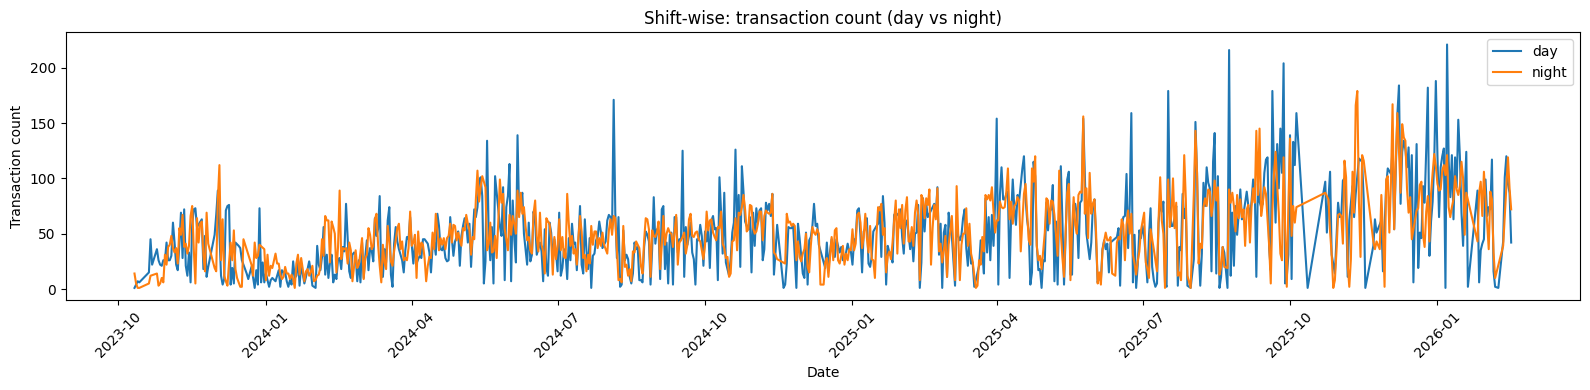

In [8]:

# Build shift aggregates (run this cell first)
df = incoming_with_comp.copy()
df['txn_time'] = pd.to_datetime(df['txn_time'])
df['date'] = df['txn_time'].dt.date
df['hour'] = df['txn_time'].dt.hour
df['shift_label'] = (df['hour'] >= 6) & (df['hour'] < 18)
df['shift_label'] = df['shift_label'].map({True: 'day', False: 'night'})
shift_agg = df.groupby(['date', 'shift_label']).agg(
    txn_count=('id', 'count'),
    parts_count=('item_number', 'nunique'),
    total_weight=('quantity', 'sum')
).reset_index()
shift_agg['date'] = pd.to_datetime(shift_agg['date'])

# Shift-wise count (wide)
fig, ax = plt.subplots(figsize=(16, 4))
for label in ['day', 'night']:
    s = shift_agg[shift_agg['shift_label'] == label]
    ax.plot(s['date'], s['txn_count'], label=label)
ax.set_ylabel('Transaction count')
ax.set_xlabel('Date')
ax.set_title('Shift-wise: transaction count (day vs night)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

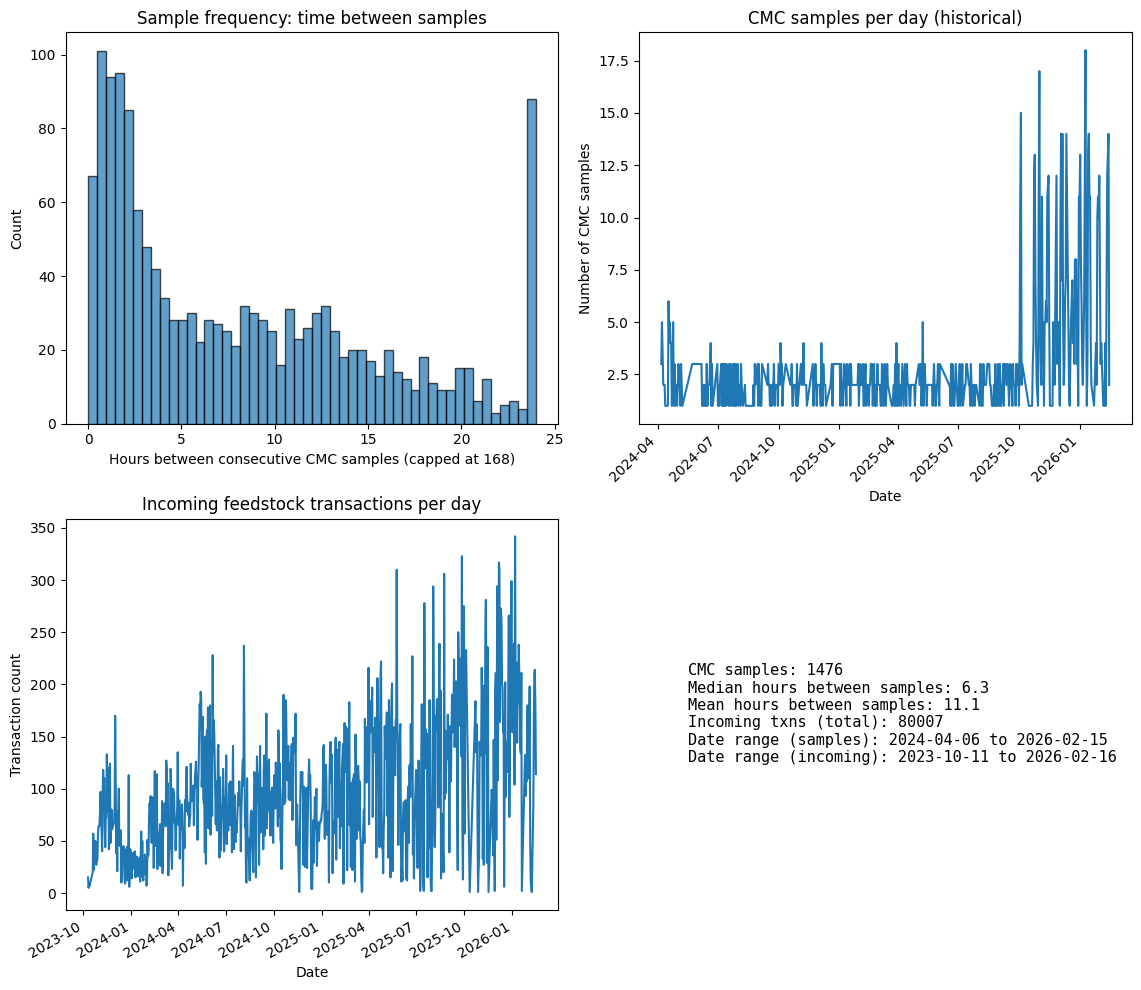

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

samples['start_time'] = pd.to_datetime(samples['start_time_local'])
samples_sorted = samples.sort_values('start_time').reset_index(drop=True)

# Time between consecutive CMC samples (hours)
sample_gaps = samples_sorted['start_time'].diff().dt.total_seconds() / 3600
sample_gaps = sample_gaps.dropna()

# Samples per day
samples_sorted['date'] = samples_sorted['start_time'].dt.date
samples_per_day = samples_sorted.groupby('date').size()
samples_per_day.index = pd.to_datetime(samples_per_day.index)

# Incoming: transactions per day
incoming_with_comp['txn_date'] = incoming_with_comp['txn_time'].dt.date
txns_per_day = incoming_with_comp.groupby('txn_date').agg(
    txn_count=('id', 'count'),
    total_quantity=('quantity', 'sum')
).reset_index()
txns_per_day['txn_date'] = pd.to_datetime(txns_per_day['txn_date'])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Histogram: hours between consecutive CMC samples
axes[0, 0].hist(sample_gaps.clip(upper=24), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Hours between consecutive CMC samples (capped at 168)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Sample frequency: time between samples')

# 2) Samples per day over time (shows increase in frequency recently)
samples_per_day.plot(ax=axes[0, 1], legend=False)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Number of CMC samples')
axes[0, 1].set_title('CMC samples per day (historical)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) Incoming transaction count per day over time
txns_per_day.plot(x='txn_date', y='txn_count', ax=axes[1, 0], legend=False)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Transaction count')
axes[1, 0].set_title('Incoming feedstock transactions per day')

# 4) Summary stats
axes[1, 1].axis('off')
stats_text = (
    f"CMC samples: {len(samples_sorted)}\n"
    f"Median hours between samples: {sample_gaps.median():.1f}\n"
    f"Mean hours between samples: {sample_gaps.mean():.1f}\n"
    f"Incoming txns (total): {len(incoming_with_comp)}\n"
    f"Date range (samples): {samples_sorted['start_time'].min().date()} to {samples_sorted['start_time'].max().date()}\n"
    f"Date range (incoming): {incoming_with_comp['txn_time'].min().date()} to {incoming_with_comp['txn_time'].max().date()}"
)
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', family='monospace')

plt.tight_layout()
plt.show()

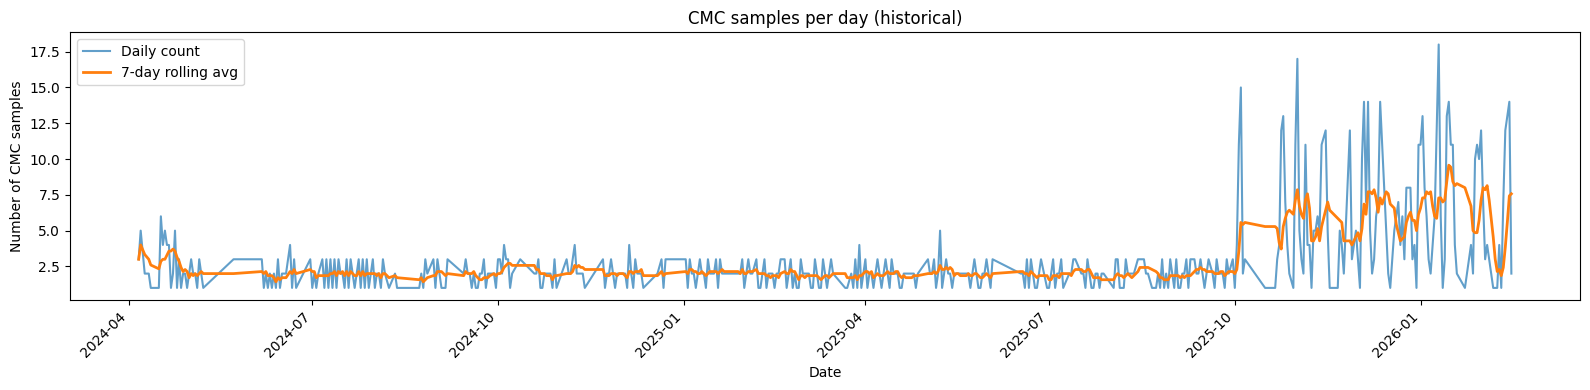

In [10]:
# CMC samples per day — separate figure with higher width and rolling average trend
ROLLING_DAYS = 7  # 7-day rolling average for trend
fig, ax = plt.subplots(figsize=(16, 4))
samples_per_day.plot(ax=ax, label='Daily count', alpha=0.7)
samples_per_day.rolling(ROLLING_DAYS, min_periods=1).mean().plot(ax=ax, label=f'{ROLLING_DAYS}-day rolling avg', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of CMC samples')
ax.set_title('CMC samples per day (historical)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Filter: net_weight >= 500
Samples removed (weight < 500 or null): 28
Samples retained: 1439

Statistics (net_weight, kg):
  Mean:    832.10
  Median:  817.00
  Variance: 5010.06


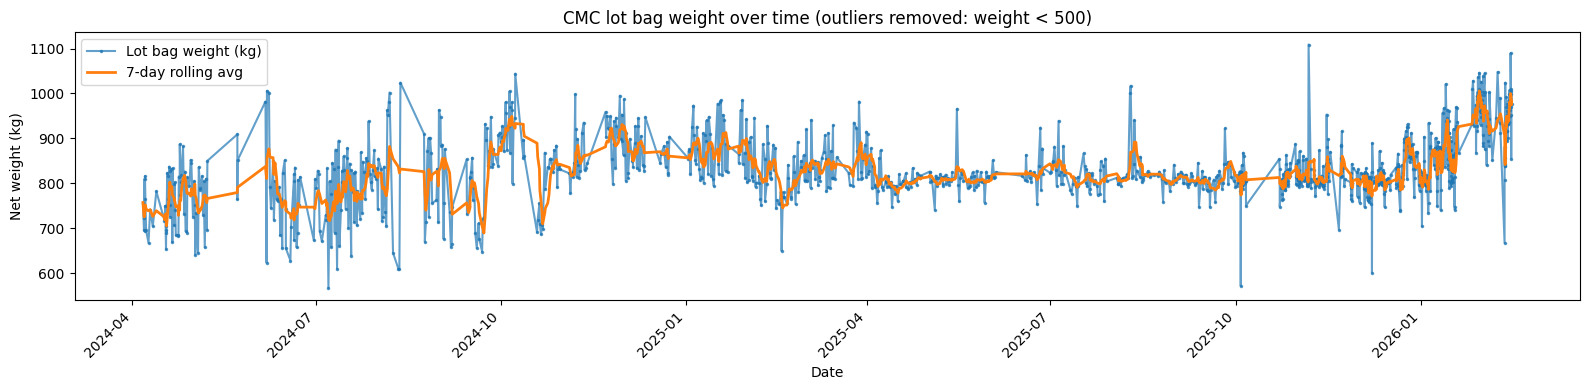

In [11]:
# Remove outliers: keep only samples with net_weight >= 500
WEIGHT_MIN = 500
weight_df_filtered = samples_sorted[['start_time', 'net_weight']].dropna(subset=['net_weight'])
weight_df_filtered = weight_df_filtered[weight_df_filtered['net_weight'] >= WEIGHT_MIN]
weight_df_filtered = weight_df_filtered.sort_values('start_time').set_index('start_time')
weight_filtered = weight_df_filtered['net_weight']

# Statistics
mean_w = weight_filtered.mean()
median_w = weight_filtered.median()
var_w = weight_filtered.var()
n_removed = len(samples_sorted.dropna(subset=['net_weight'])) - len(weight_filtered)

print(f"Filter: net_weight >= {WEIGHT_MIN}")
print(f"Samples removed (weight < {WEIGHT_MIN} or null): {n_removed}")
print(f"Samples retained: {len(weight_filtered)}")
print(f"\nStatistics (net_weight, kg):")
print(f"  Mean:    {mean_w:.2f}")
print(f"  Median:  {median_w:.2f}")
print(f"  Variance: {var_w:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(16, 4))
weight_filtered.plot(ax=ax, label='Lot bag weight (kg)', alpha=0.7, marker='.', markersize=3)
weight_filtered.rolling(7, min_periods=1).mean().plot(ax=ax, label='7-day rolling avg', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Net weight (kg)')
ax.set_title(f'CMC lot bag weight over time (outliers removed: weight < {WEIGHT_MIN})')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 4. For each sample: time window and feedstock aggregates

**Dynamic window** (time diff between lots): Feed window for a lot is **(previous_lot_end - residence, this_lot_end - residence]**. Residence time = **2 hr 10 min** (RC1/MS4: ~20 min infeed + 1 hr kiln + 50 min HTC to bagging). First lot uses a lookback (e.g. 12 hr) for window start. Only feed in this window is aggregated for that sample.

In [12]:
# Dynamic feed window: (previous_lot_end - residence, this_lot_end - residence]
residence_delta = timedelta(minutes=RESIDENCE_MINUTES)
first_lot_lookback = timedelta(hours=FIRST_LOT_LOOKBACK_HOURS)
rows = []

for i in range(len(samples)):
    row = samples.iloc[i]
    sample_id = row['effective_sample_id']
    lot_end = row['lot_end_time']
    t_end = lot_end - residence_delta   # last feed that could contribute to this lot

    if i == 0:
        t_start = t_end - first_lot_lookback
    else:
        prev_lot_end = samples.iloc[i - 1]['lot_end_time']
        t_start = prev_lot_end - residence_delta  # feed after this went to this lot

    in_window = incoming_with_comp[(incoming_with_comp['txn_time'] > t_start) & (incoming_with_comp['txn_time'] <= t_end)]

    total_qty = in_window['quantity'].sum()
    matched = in_window.dropna(subset=['item_code'])
    matched_qty = matched['quantity'].sum()

    if total_qty == 0:
        feed_ni_pct = feed_co_pct = feed_ni_co_ratio = np.nan
        feed_mass_matched_pct = 0.0
    else:
        feed_mass_matched_pct = matched_qty / total_qty
        if matched_qty == 0:
            feed_ni_pct = feed_co_pct = feed_ni_co_ratio = np.nan
        else:
            feed_ni_pct = (matched['quantity'] * matched['wt_ni_percent']).sum() / matched_qty
            feed_co_pct = (matched['quantity'] * matched['wt_co_percent']).sum() / matched_qty
            feed_ni_co_ratio = feed_ni_pct / feed_co_pct if feed_co_pct and feed_co_pct != 0 else np.nan

    feed_item_count = in_window['item_number'].nunique()
    hours_since_prev_lot = (lot_end - samples.iloc[i - 1]['lot_end_time']).total_seconds() / 3600 if i > 0 else np.nan

    # Categorical: most frequent cathode_chemistry in feed window (for downstream encoding)
    feed_cathode_chemistry = None
    if 'cathode_chemistry' in in_window.columns and len(in_window) > 0:
        cc_clean = in_window['cathode_chemistry'].dropna()
        feed_cathode_chemistry = cc_clean.mode().iloc[0] if len(cc_clean) > 0 else None

    row_dict = {
        'effective_sample_id': sample_id,
        'sample_id': row.get('sample_id'),
        'start_time_local': row['start_time_local'],
        'end_time_local': row.get('end_time_local'),
        'lot_number': row.get('lot_number'),
        'nickel_ppm': row['nickel_ppm'],
        'cobalt_ppm': row['cobalt_ppm'],
        'net_weight': row.get('net_weight'),
        'sample_type': row.get('sample_type'),
        'feed_ni_pct_wt_avg': feed_ni_pct,
        'feed_co_pct_wt_avg': feed_co_pct,
        'feed_ni_co_ratio': feed_ni_co_ratio,
        'feed_total_quantity': total_qty,
        'feed_item_count': feed_item_count,
        'feed_mass_matched_pct': feed_mass_matched_pct,
        'hours_since_prev_lot': hours_since_prev_lot,
        'hours_to_matched_sample': row.get('hours_to_matched_sample'),
    }
    if feed_cathode_chemistry is not None:
        row_dict['feed_cathode_chemistry'] = feed_cathode_chemistry
    rows.append(row_dict)

ml_table = pd.DataFrame(rows)
# Keep categorical column as string/category for downstream encoding
if 'feed_cathode_chemistry' in ml_table.columns:
    ml_table['feed_cathode_chemistry'] = ml_table['feed_cathode_chemistry'].astype('category')

ml_table['hour_of_day'] = pd.to_datetime(ml_table['start_time_local']).dt.hour
ml_table['day_of_week'] = pd.to_datetime(ml_table['start_time_local']).dt.dayofweek
ml_table['shift'] = (ml_table['hour_of_day'] >= 6) & (ml_table['hour_of_day'] < 18)  # day=True, night=False

print('ML feature table:', ml_table.shape)
ml_table.head(10)

ML feature table: (1476, 21)


,effective_sample_id,sample_id,start_time_local,end_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,feed_ni_pct_wt_avg,...,feed_ni_co_ratio,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,feed_cathode_chemistry,hour_of_day,day_of_week,shift
0,AA33486,AA33486,2024-04-06 05:59:27,2024-04-06 07:00:55,0030262404060001-1,288582.2,71656.8,757.0,single,0.093513,...,1.278193,19225.0,5,1.0,NaN,0.000000,LCO,5,5,False
1,AA33559,AA33559,2024-04-06 18:08:13,2024-04-06 18:54:17,0030262404060001-17,230774.2,61657.1,696.0,inferred_single,0.072244,...,5.003001,23744.3,5,1.0,11.889444,1.808889,NMC,18,5,False
2,AA33563,AA33563,2024-04-06 21:41:17,2024-04-06 22:21:51,0030262404060001-24,231206.1,62430.3,722.0,inferred_single,0.127168,...,6.613785,6297.0,3,1.0,3.459444,1.638611,NCA,21,5,False
3,AA33588,AA33588,2024-04-07 01:04:18,2024-04-07 01:38:59,0030262404070001-6,228489.7,55806.3,810.0,inferred_single,0.097586,...,8.341603,11728.0,3,1.0,3.285556,1.153611,NCA,1,6,False
4,AA33615,AA33615,2024-04-07 04:07:04,2024-04-07 04:54:22,0030262404070001-11,242990.6,56770.4,693.0,inferred_single,0.066388,...,4.648571,11589.0,3,1.0,3.256389,0.349722,NMC,4,6,False
5,AA33639,AA33639,2024-04-07 06:00:53,2024-04-07 06:56:44,0030262404070001-14,350103.2,34512.0,816.0,single,0.190781,...,7.669210,2817.0,2,1.0,2.039444,0.000000,NCA,6,6,True
6,AA33645,AA33645,2024-04-07 10:41:03,2024-04-07 11:09:11,0030262404070001-20,347889.7,32294.2,766.0,inferred_single,0.072728,...,6.779304,11806.0,4,1.0,4.207500,-3.472778,NCA,10,6,True
7,AA33708,AA33708,2024-04-07 19:15:23,2024-04-07 19:29:30,0030262404070001-32,314700.6,36990.4,696.0,inferred_single,0.136225,...,7.580106,14514.0,4,1.0,8.338611,-0.581944,NCA,19,6,False
8,AA33903,AA33903,2024-04-09 00:05:45,2024-04-09 00:51:21,0030262404090001-2,376699.8,22423.2,667.0,inferred_single,0.025404,...,4.858348,80567.5,6,1.0,29.364167,-5.800556,NMC,0,1,False
9,AA33976,AA33976,2024-04-09 19:50:54,2024-04-09 20:37:08,0030262404090001-36,219817.2,52352.2,741.0,inferred_single,0.113844,...,3.901691,51445.0,3,1.0,19.763056,-13.768888,NMC,19,1,False


### Residence time validation (two metrics)

We sweep candidate residence times to find the best **time alignment** between incoming feed and CMC lot end time.

1. **Ratio stability:** The ratio **feed_total_quantity / net_weight** should be relatively **stable** when the window is correct. Residence that **minimizes std(ratio)** is one candidate.
2. **Feed–CMC correlation (below):** Feed composition (mass-weighted Ni/Co %) should **correlate** with lab Ni/Co when alignment is right. Residence that **maximizes** these correlations is the best-aligned window.

Ratio (feed_qty / net_weight) stability by residence time (1 <= ratio <= 100):


,residence_min,std,mean,cv_pct,n
0,90,24.3668,27.7268,87.8817,1308
1,110,24.3165,27.8086,87.4424,1305
2,130,24.0871,27.8303,86.5499,1292
3,150,24.0109,27.9526,85.8986,1283
4,180,24.1577,28.0294,86.1869,1284


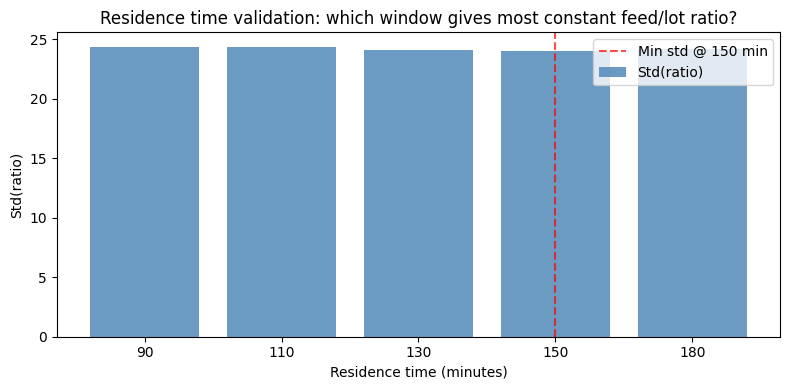

Recommended: residence = 150 min (lowest std of ratio). Current RESIDENCE_MINUTES = 130.


In [13]:
# Sweep residence times: which gives the most stable ratio (feed_qty / net_weight)?
RESIDENCE_CANDIDATES_MIN = [90, 110, 130, 150, 180]  # minutes to try
first_lot_lookback = timedelta(hours=FIRST_LOT_LOOKBACK_HOURS)
residence_stats = []
for res_min in RESIDENCE_CANDIDATES_MIN:
    residence_delta = timedelta(minutes=res_min)
    ratios = []
    for i in range(len(samples)):
        row = samples.iloc[i]
        lot_end = row['lot_end_time']
        t_end = lot_end - residence_delta
        if i == 0:
            t_start = t_end - first_lot_lookback
        else:
            prev_lot_end = samples.iloc[i - 1]['lot_end_time']
            t_start = prev_lot_end - residence_delta
        in_window = incoming_with_comp[(incoming_with_comp['txn_time'] > t_start) & (incoming_with_comp['txn_time'] <= t_end)]
        total_qty = in_window['quantity'].sum()
        nw = row.get('net_weight')
        if pd.notna(nw) and nw > 0 and total_qty > 0:
            r = total_qty / nw
            if 1 <= r <= 100:  # same sanity as ML filter
                ratios.append(r)
    ratios = np.array(ratios) if ratios else np.array([np.nan])
    mean_r = np.nanmean(ratios)
    std_r = np.nanstd(ratios)
    cv_r = (std_r / mean_r * 100) if mean_r and mean_r > 0 else np.nan
    residence_stats.append({'residence_min': res_min, 'std': std_r, 'mean': mean_r, 'cv_pct': cv_r, 'n': len(ratios)})
res_df = pd.DataFrame(residence_stats)
print('Ratio (feed_qty / net_weight) stability by residence time (1 <= ratio <= 100):')
display(res_df.round(4))
# Plot: residence that minimizes std or CV is a good candidate for "right" window
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(res_df['residence_min'].astype(str), res_df['std'], color='steelblue', alpha=0.8, label='Std(ratio)')
ax.set_xlabel('Residence time (minutes)')
ax.set_ylabel('Std(ratio)')
ax.set_title('Residence time validation: which window gives most constant feed/lot ratio?')
best_idx = res_df['std'].values.argmin()
best_min_plot = int(res_df.iloc[best_idx]['residence_min'])
ax.axvline(x=best_idx, color='red', linestyle='--', alpha=0.7, label=f"Min std @ {best_min_plot} min")
ax.legend()
plt.tight_layout()
plt.show()
best_min = int(res_df.loc[res_df['std'].idxmin(), 'residence_min'])
print(f'Recommended: residence = {best_min_plot} min (lowest std of ratio). Current RESIDENCE_MINUTES = {RESIDENCE_MINUTES}.')

### Alignment metric: correlation of feed composition with CMC lab results

If the **time window is aligned** correctly, feed composition (mass-weighted Ni/Co %) should **correlate** with CMC lab results (nickel_ppm, cobalt_ppm). For each candidate residence we build feed_ni_pct and feed_co_pct per sample, then compute correlation with lab Ni/Co. The residence that **maximizes** these correlations is the best-aligned window.

Feed–CMC alignment: correlation of feed composition with lab results by residence time:


,residence_min,corr_ni,corr_co,n
0,90,0.6264,0.4326,1308
1,110,0.6319,0.4302,1305
2,130,0.6198,0.4113,1292
3,150,0.6075,0.4386,1283
4,180,0.6104,0.4706,1284


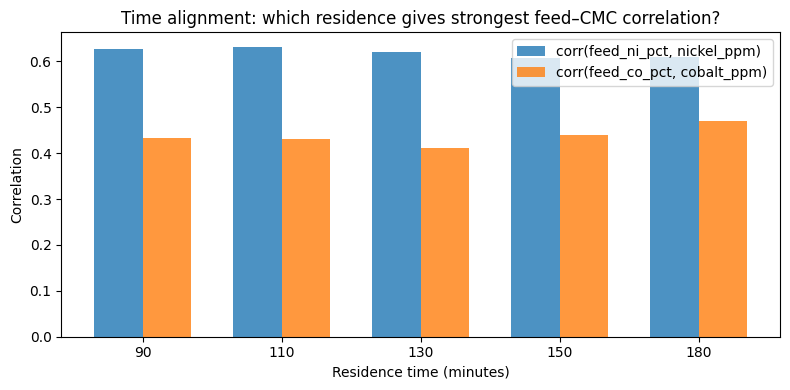

Best alignment (max avg correlation): residence = 180 min. Current RESIDENCE_MINUTES = 130.


In [14]:
# Alignment metric: for each residence, compute feed composition and correlation with lab Ni/Co
first_lot_lookback = timedelta(hours=FIRST_LOT_LOOKBACK_HOURS)
align_stats = []
for res_min in RESIDENCE_CANDIDATES_MIN:
    residence_delta = timedelta(minutes=res_min)
    rows_align = []
    for i in range(len(samples)):
        row = samples.iloc[i]
        lot_end = row['lot_end_time']
        t_end = lot_end - residence_delta
        if i == 0:
            t_start = t_end - first_lot_lookback
        else:
            prev_lot_end = samples.iloc[i - 1]['lot_end_time']
            t_start = prev_lot_end - residence_delta
        in_window = incoming_with_comp[(incoming_with_comp['txn_time'] > t_start) & (incoming_with_comp['txn_time'] <= t_end)]
        total_qty = in_window['quantity'].sum()
        matched = in_window.dropna(subset=['item_code'])
        matched_qty = matched['quantity'].sum()
        if total_qty == 0 or matched_qty == 0:
            feed_ni_pct = feed_co_pct = np.nan
        else:
            feed_ni_pct = (matched['quantity'] * matched['wt_ni_percent']).sum() / matched_qty
            feed_co_pct = (matched['quantity'] * matched['wt_co_percent']).sum() / matched_qty
        nw = row.get('net_weight')
        ratio = (total_qty / nw) if pd.notna(nw) and nw > 0 and total_qty > 0 else np.nan
        rows_align.append({
            'nickel_ppm': row.get('nickel_ppm'), 'cobalt_ppm': row.get('cobalt_ppm'),
            'feed_ni_pct': feed_ni_pct, 'feed_co_pct': feed_co_pct, 'ratio': ratio
        })
    df_align = pd.DataFrame(rows_align)
    # Restrict to valid ratio (same as ML filter) and non-null targets/feed
    valid = df_align.dropna(subset=['nickel_ppm', 'cobalt_ppm', 'feed_ni_pct', 'feed_co_pct'])
    valid = valid[(valid['ratio'] >= 1) & (valid['ratio'] <= 100)]
    if len(valid) < 20:
        align_stats.append({'residence_min': res_min, 'corr_ni': np.nan, 'corr_co': np.nan, 'n': len(valid)})
        continue
    corr_ni = valid['feed_ni_pct'].corr(valid['nickel_ppm'])
    corr_co = valid['feed_co_pct'].corr(valid['cobalt_ppm'])
    align_stats.append({'residence_min': res_min, 'corr_ni': corr_ni, 'corr_co': corr_co, 'n': len(valid)})
align_df = pd.DataFrame(align_stats)
print('Feed–CMC alignment: correlation of feed composition with lab results by residence time:')
display(align_df.round(4))
# Plot: residence that maximizes correlation = best alignment
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(align_df))
w = 0.35
ax.bar(x - w/2, align_df['corr_ni'], w, label='corr(feed_ni_pct, nickel_ppm)', color='C0', alpha=0.8)
ax.bar(x + w/2, align_df['corr_co'], w, label='corr(feed_co_pct, cobalt_ppm)', color='C1', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(align_df['residence_min'].astype(int))
ax.set_xlabel('Residence time (minutes)')
ax.set_ylabel('Correlation')
ax.set_title('Time alignment: which residence gives strongest feed–CMC correlation?')
ax.axhline(0, color='gray', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.show()
# Recommend by average correlation (or by corr_ni if Ni is priority)
align_df['corr_avg'] = (align_df['corr_ni'].fillna(0) + align_df['corr_co'].fillna(0)) / 2
best_align_idx = align_df['corr_avg'].idxmax()
best_align_min = int(align_df.loc[best_align_idx, 'residence_min'])
print(f'Best alignment (max avg correlation): residence = {best_align_min} min. Current RESIDENCE_MINUTES = {RESIDENCE_MINUTES}.')

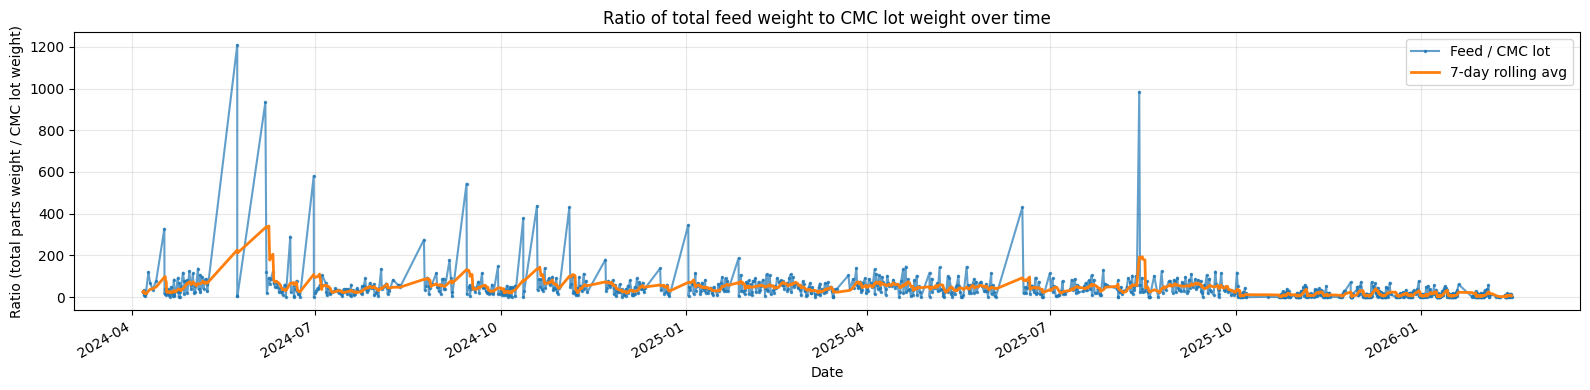

In [15]:
# Ratio: total parts (feed) weight / CMC lot weight over time
ratio_df = ml_table[ml_table['net_weight'] > 0].copy()
ratio_df['start_time'] = pd.to_datetime(ratio_df['start_time_local'])
ratio_df['ratio_feed_to_lot'] = ratio_df['feed_total_quantity'] / ratio_df['net_weight']
ratio_df = ratio_df.sort_values('start_time').set_index('start_time')

fig, ax = plt.subplots(figsize=(16, 4))
ratio_df['ratio_feed_to_lot'].plot(ax=ax, label='Feed / CMC lot', alpha=0.7, marker='.', markersize=3)
ratio_df['ratio_feed_to_lot'].rolling(7, min_periods=1).mean().plot(ax=ax, label='7-day rolling avg', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Ratio (total parts weight / CMC lot weight)')
ax.set_title('Ratio of total feed weight to CMC lot weight over time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Removed 153 points with ratio < 1 or ratio > 100. Plotting 1292 points.

Ratio (total parts weight / CMC lot weight) — stats (outliers removed):
count    1292.000000
mean       27.830263
std        24.096401
min         1.022054
25%         8.123596
50%        19.853781
75%        42.745103
max        98.075030

Percentiles: 5% = 2.50, 25% = 8.12, 50% = 19.85, 75% = 42.75, 95% = 78.43


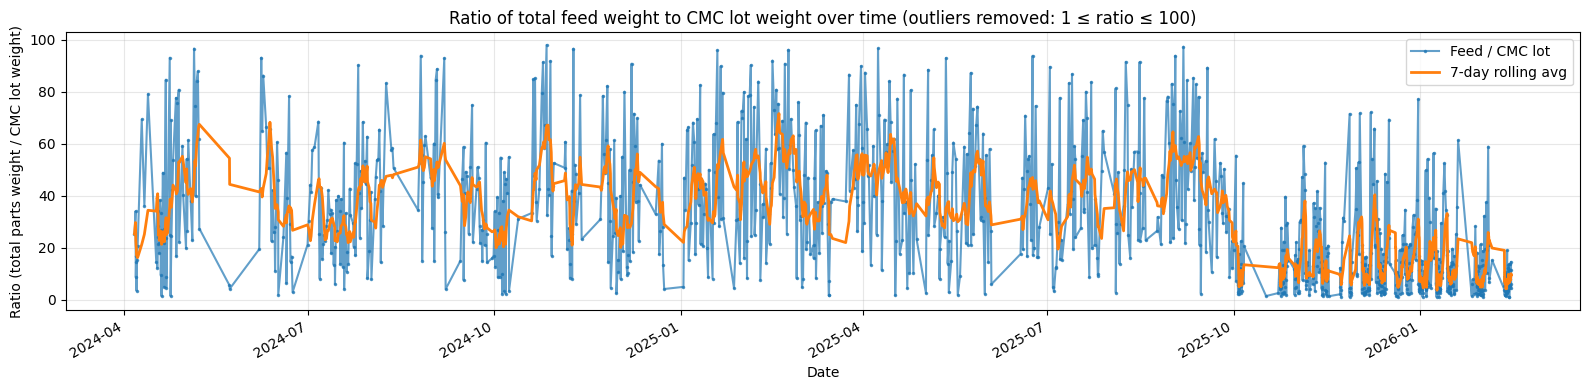

In [16]:
# Remove ratio outliers: keep 1 <= ratio <= 100, replot
ratio_df_filtered = ratio_df[(ratio_df['ratio_feed_to_lot'] >= 1) & (ratio_df['ratio_feed_to_lot'] <= 100)].copy()
n_removed = len(ratio_df) - len(ratio_df_filtered)
print(f'Removed {n_removed} points with ratio < 1 or ratio > 100. Plotting {len(ratio_df_filtered)} points.')

# Summary stats for ratio (feed / CMC lot), 1 ≤ ratio ≤ 100
r = ratio_df_filtered['ratio_feed_to_lot']
print('\nRatio (total parts weight / CMC lot weight) — stats (outliers removed):')
print(r.describe().to_string())
print(f'\nPercentiles: 5% = {r.quantile(0.05):.2f}, 25% = {r.quantile(0.25):.2f}, 50% = {r.quantile(0.50):.2f}, 75% = {r.quantile(0.75):.2f}, 95% = {r.quantile(0.95):.2f}')

fig, ax = plt.subplots(figsize=(16, 4))
ratio_df_filtered['ratio_feed_to_lot'].plot(ax=ax, label='Feed / CMC lot', alpha=0.7, marker='.', markersize=3)
ratio_df_filtered['ratio_feed_to_lot'].rolling(7, min_periods=1).mean().plot(ax=ax, label='7-day rolling avg', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Ratio (total parts weight / CMC lot weight)')
ax.set_title('Ratio of total feed weight to CMC lot weight over time (outliers removed: 1 ≤ ratio ≤ 100)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4.1 Feature map (ML table)

| Column | Type | Description |
|--------|------|-------------|
| **Keys / identifiers** | | |
| effective_sample_id | str | LIMS sample ID (use for one row per sample). |
| sample_id | str | Raw sample ID; effective_sample_id imputes when missing. |
| lot_number | str | Individual bag/pallet of finished goods. |
| start_time_local | datetime | Sample start time (local). |
| end_time_local | datetime | Lot done / ready for sampling (feed window reference). |
| **Targets** | | |
| nickel_ppm | float | Lab Ni in CMC (ppm). |
| cobalt_ppm | float | Lab Co in CMC (ppm). |
| **Feedstock (time-aligned)** | | |
| feed_ni_pct_wt_avg | float | Mass-weighted avg Ni % in feed in this lot's window. |
| feed_co_pct_wt_avg | float | Mass-weighted avg Co % in feed in this lot's window. |
| feed_ni_co_ratio | float | feed_ni_pct_wt_avg / feed_co_pct_wt_avg. |
| feed_total_quantity | float | Total feed quantity in window. |
| feed_item_count | int | Distinct item_number (part types) in window. |
| feed_mass_matched_pct | float | Fraction of feed quantity matched to master list. |
| feed_cathode_chemistry | category | Most frequent cathode_chemistry in feed window (categorical; encode downstream). |
| **Process / temporal** | | |
| hours_since_prev_lot | float | Hours from previous lot end to this lot end (dynamic fill). |
| hour_of_day | int | 0-23. |
| day_of_week | int | 0-6 (Monday=0). |
| shift | bool | True = day (6-18), False = night. |
| **Context** | | |
| net_weight | float | CMC lot bag weight (kg). |
| sample_type | str | e.g. composite, inferred_composite, single. |

## 5. Save ML feature table

Write to parquet (or CSV) for training/inference. Optionally filter to rows with at least some matched feedstock.

In [17]:
# Optional: keep only rows with feedstock in window (or keep all and flag)
ml_table_with_feed = ml_table[ml_table['feed_total_quantity'] > 0]
print('Samples with at least one transaction in window:', len(ml_table_with_feed))

import os
os.makedirs(os.path.dirname(PATH_ML_TABLE) or '.', exist_ok=True)
ml_table_with_feed.to_parquet(PATH_ML_TABLE, index=False)
print('Saved to', PATH_ML_TABLE)

Samples with at least one transaction in window: 1420
Saved to data/ml_feature_table.parquet
